# Encoder test bed

In [1]:
%reload_ext autoreload
%autoreload all

%aimport -torch
%aimport -matplotlib
%aimport -seaborn
%aimport -numpy
%aimport -pandas
%aimport -scipy

In [2]:
from dataset import CHBMITDataset

data_path = "./CHB-MIT/processed"
dataset = CHBMITDataset(data_path)

## Load the dataset

In [3]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

## Create utils

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_coding(original_data, spike_data, decoded_data):
    figs, axes = plt.subplots(3, 1, figsize=(10, 8))
    figs.set_tight_layout(True)
    axes[0].set_title("Encoded Spike Train")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Spike")
    axes[0].stem(spike_data, markerfmt="none")
    axes[1].set_title("Original Signal")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Amplitude")
    sns.lineplot(original_data, ax=axes[1])
    axes[2].set_title("Decoded Signal")
    axes[2].set_xlabel("Timesteps")
    axes[2].set_ylabel("Amplitude")
    sns.lineplot(decoded_data, ax=axes[2])

## Get the dataset

In [5]:
test_data, test_label = next(iter(data_loader))

In [6]:
import torch

from utils.preprocess import VectorizeSTFT

stft_data = VectorizeSTFT(test_data)
magnitudes = torch.abs(stft_data)
angles = torch.angle(stft_data)

In [7]:
def normalize(x: torch.Tensor) -> torch.Tensor:
    x_min = x.min(dim=-1, keepdim=True).values
    x_max = x.max(dim=-1, keepdim=True).values

    diff = x_max - x_min
    diff[diff == 0] = 1.0

    return (x - x_min) / diff

In [8]:
normalized_magnitudes = normalize(magnitudes)

## Load the encoder

In [9]:
from encoder import PoissonEncoder

p_encoder = PoissonEncoder(interval_freq=4, random_seed=24)
encoded_data = p_encoder.encode(magnitudes)
decoded_rate = p_encoder.decode(encoded_data)

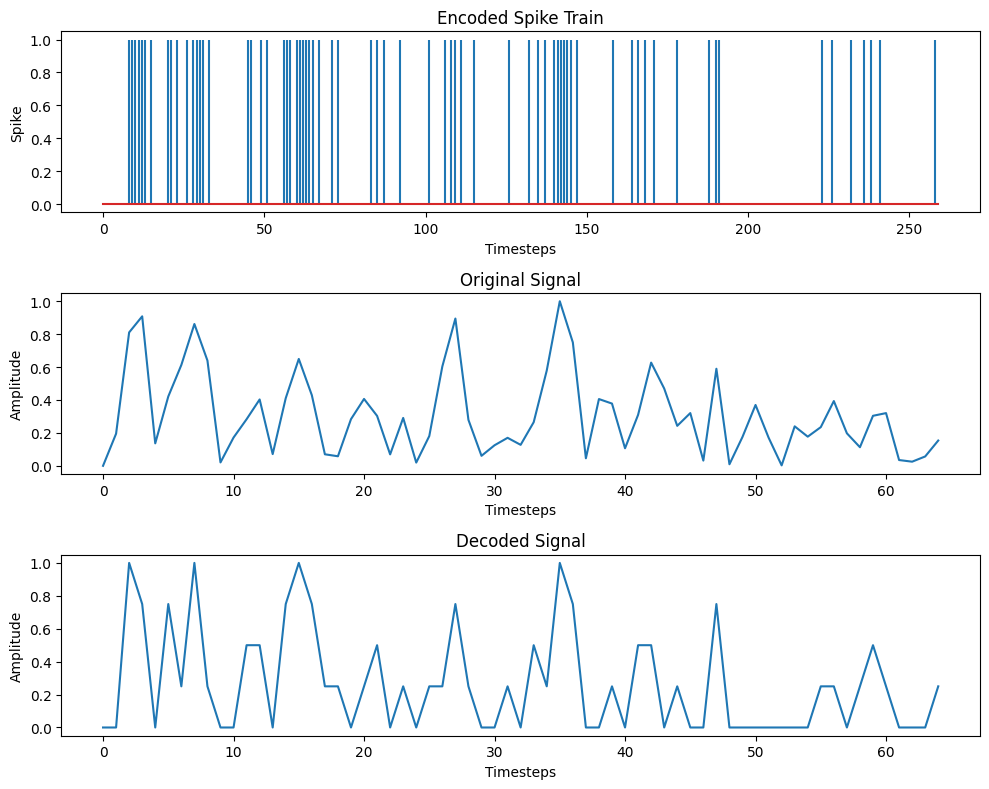

In [10]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_rate[0,0,0,:])

In [11]:
from encoder import StepForwardEncoder

sf_encoder = StepForwardEncoder(threshold=0.19606764001960716)
base = normalized_magnitudes.select(-1, 0)
encoded_data = sf_encoder.encode(magnitudes)
decoded_data = sf_encoder.decode(encoded_data, base=base)

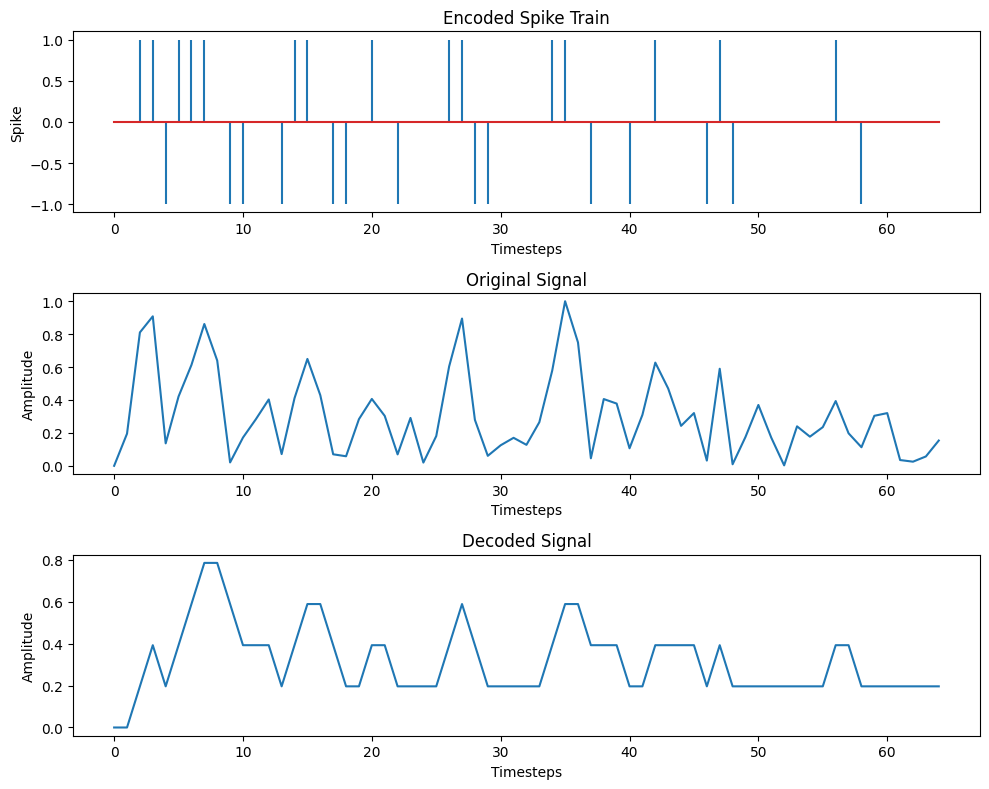

In [12]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_data[0,0,0,:])

In [13]:
from encoder import TBREncoder

tbr_encoder = TBREncoder(threshold=0.40992623011415186)
base, threshold = tbr_encoder.get_decode_parameters(normalized_magnitudes)
encoded_data = tbr_encoder.encode(magnitudes)
decoded_data = tbr_encoder.decode(encoded_data, base=base, threshold=threshold)

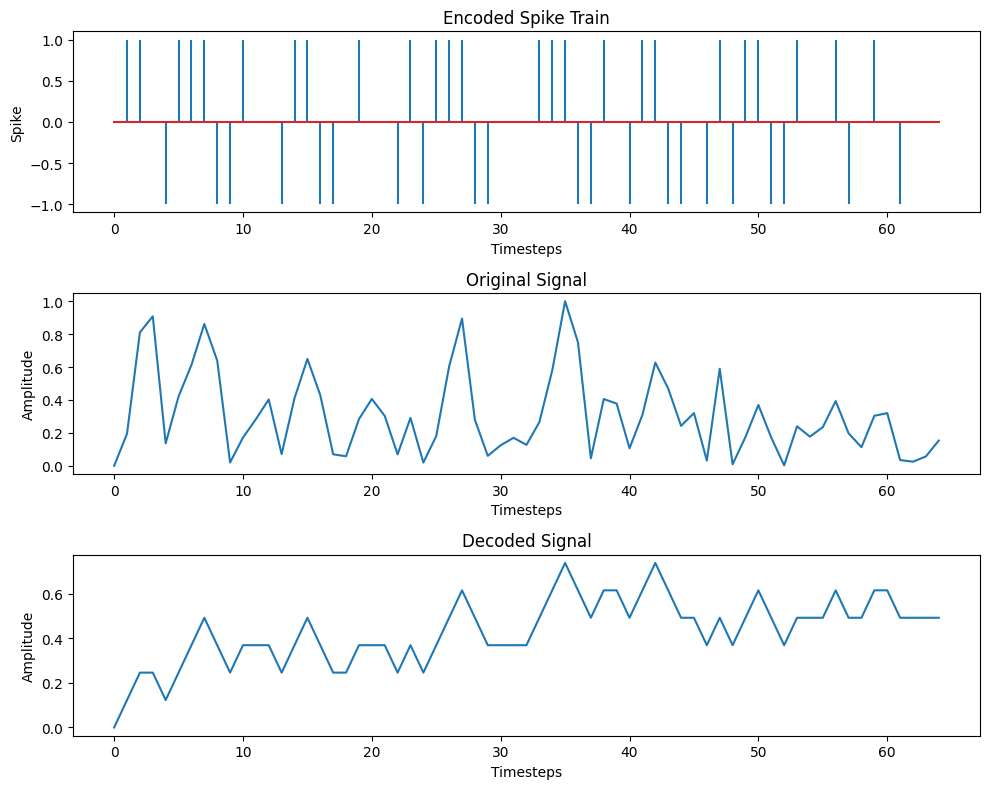

In [14]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_data[0,0,0,:])

In [39]:
from encoder import BSAEncoder

bsa_encoder = BSAEncoder(win_size=6, cutoff=0.15678260630598448, threshold=0.4054443922810268)
encoded_data = bsa_encoder.encode(magnitudes)
decoded_data = bsa_encoder.decode(encoded_data)

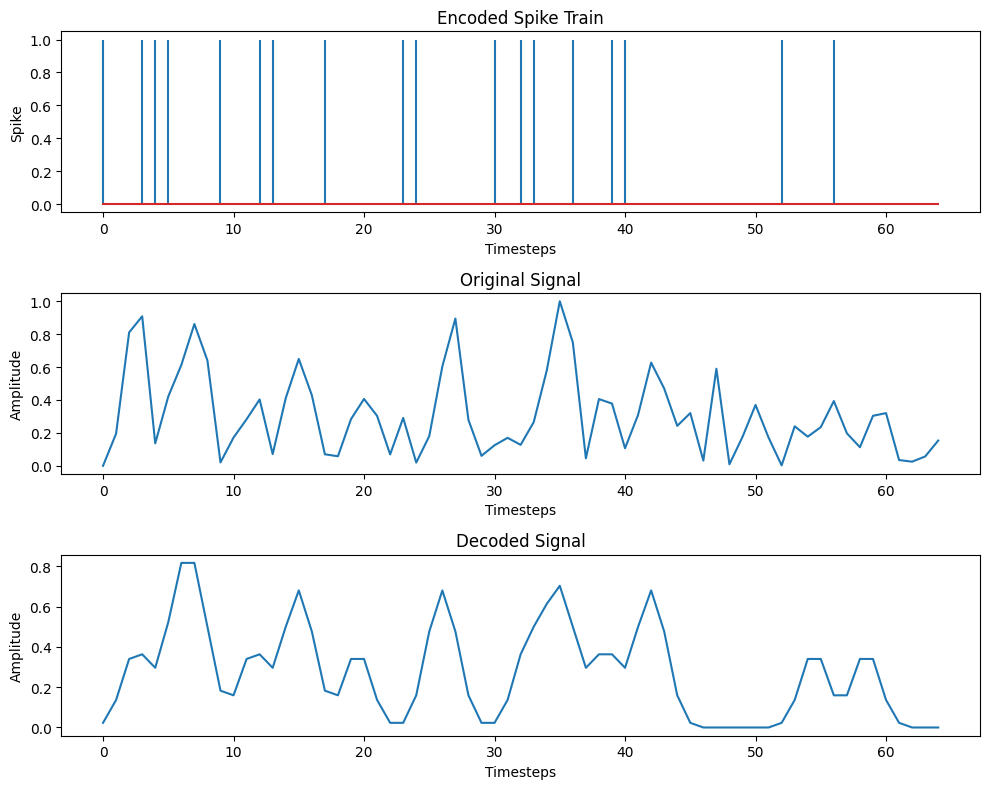

In [42]:
plot_coding(normalized_magnitudes[0,0,0,:], encoded_data[0,0,0,:], decoded_data[0,0,0,:])

In [37]:
import optuna


def objective(trial: optuna.Trial) -> float:
    win_size = trial.suggest_int("win_size", 4, 16, step=2)
    cutoff = trial.suggest_float("cutoff", 0.05, 0.45)
    threshold = trial.suggest_float("threshold", 0.1, 0.99)

    bsa_encoder = BSAEncoder(win_size=win_size, cutoff=cutoff, threshold=threshold)
    encoded_data = bsa_encoder.encode(magnitudes)
    decoded_data = bsa_encoder.decode(encoded_data)

    mse = torch.sum((normalized_magnitudes - decoded_data) ** 2).item()
    return mse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-04-27 01:07:51,187] A new study created in memory with name: no-name-a159a589-5473-4e14-92fb-c2ad48f9e92f
[I 2025-04-27 01:07:51,544] Trial 0 finished with value: 197269.484375 and parameters: {'win_size': 8, 'cutoff': 0.1443731506393489, 'threshold': 0.4825506298092418}. Best is trial 0 with value: 197269.484375.
[I 2025-04-27 01:07:51,844] Trial 1 finished with value: 192512.71875 and parameters: {'win_size': 8, 'cutoff': 0.3195019909662192, 'threshold': 0.3797112811565222}. Best is trial 1 with value: 192512.71875.
[I 2025-04-27 01:07:52,170] Trial 2 finished with value: 266516.78125 and parameters: {'win_size': 10, 'cutoff': 0.19256362692903173, 'threshold': 0.13947518334639997}. Best is trial 1 with value: 192512.71875.
[I 2025-04-27 01:07:52,460] Trial 3 finished with value: 287454.90625 and parameters: {'win_size': 8, 'cutoff': 0.1366911296650214, 'threshold': 0.8253705748951922}. Best is trial 1 with value: 192512.71875.
[I 2025-04-27 01:07:52,759] Trial 4 finished with

In [38]:
study.best_params, study.best_value

({'win_size': 6,
  'cutoff': 0.15678260630598448,
  'threshold': 0.4054443922810268},
 170901.171875)

In [34]:
study.best_params, study.best_value

({'win_size': 2,
  'cutoff': 0.0729499353924456,
  'threshold': 0.24973993913103373},
 159133.265625)